In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from net.resnet50_cam import Net
from misc import torchutils, imutils, pyutils
from PIL import Image
import matplotlib.pyplot as plt
import voc12.dataloader
from torch.utils.data import DataLoader

In [2]:
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128,
           255, 255, 255]

object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']


def colorize_mask(mask):
    if isinstance(mask, np.ndarray):
        mask = Image.fromarray(mask.astype(np.uint8))
    new_mask = mask.convert('P')
    new_mask.putpalette(palette)
    return new_mask.convert('RGB')


img_num = '2007_000333'


org_img = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012/JPEGImages/{}.jpg'.format(img_num)
# scp yipingwang@kingwood.cs.uvic.ca:/data/home/yipingwang/data/CAMv2/2007_002105.npy .
cam_dict_path = '/Users/Andy/Projects/{}.npy'.format(img_num)

img = Image.open(org_img).convert('RGB')
cams_dict = np.load(cam_dict_path, allow_pickle=True).item()
high_res = cams_dict['high_res'].squeeze()
keys = cams_dict['keys'].squeeze()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Andy/Projects/2007_000333.npy'

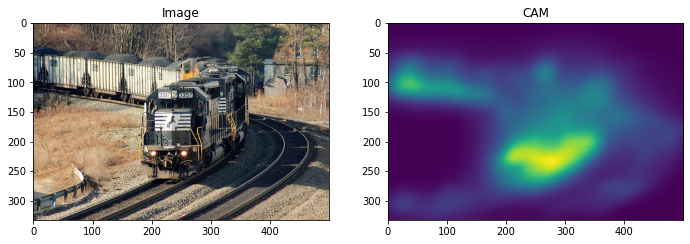

In [4]:
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(231)
plt.title('Image')
ax1.imshow(img)
ax2 = fig.add_subplot(232)
plt.title('CAM')
ax2.imshow(high_res)

In [7]:
import copy

img = np.asarray(Image.open(org_img).convert('RGB'))
cams = cams_dict['high_res']
keys = np.pad(cams_dict['keys'] + 1, (1, 0), mode='constant')


conf_fg_thres = 0.3
conf_bg_thres = 0.05

# 1. find confident fg & bg
fg_conf_cam = np.pad(cams, ((1, 0), (0, 0), (0, 0)),
                     mode='constant', constant_values=conf_fg_thres)
fg_conf_cam = np.argmax(fg_conf_cam, axis=0)

pred = imutils.crf_inference_label(
    img, fg_conf_cam, n_labels=keys.shape[0])
fg_conf = keys[pred]

bg_conf_cam = np.pad(cams, ((1, 0), (0, 0), (0, 0)),
                     mode='constant', constant_values=conf_bg_thres)
bg_conf_cam = np.argmax(bg_conf_cam, axis=0)
pred = imutils.crf_inference_label(
    img, bg_conf_cam, n_labels=keys.shape[0])
bg_conf = keys[pred]

# 2. combine confident fg & bg
conf = fg_conf.copy()
conf[fg_conf == 0] = 255
conf[bg_conf + fg_conf == 0] = 0

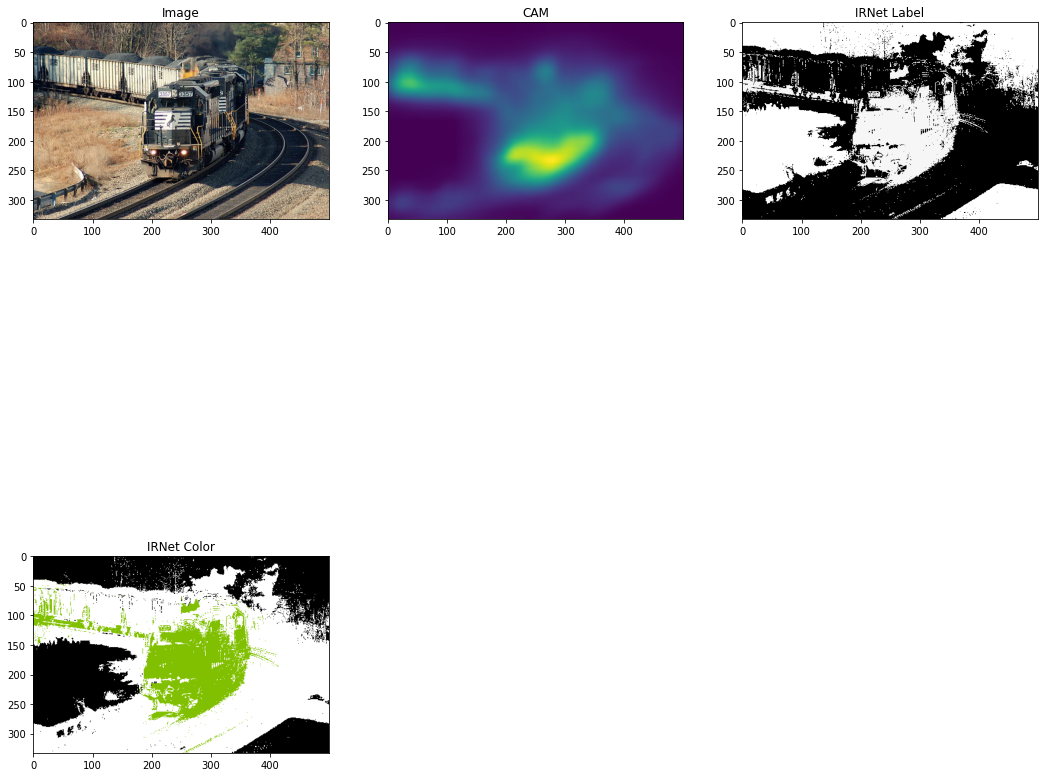

In [8]:
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(231)
plt.title('Image')
ax1.imshow(img)
ax2 = fig.add_subplot(232)
plt.title('CAM')
ax2.imshow(cams_dict['high_res'].squeeze())
ax3 = fig.add_subplot(233)
plt.title('IRNet Label')
ax3.imshow(conf, cmap='Greys')
ax4 = fig.add_subplot(234)
plt.title('IRNet Color')
ax4.imshow(colorize_mask(conf))

1.0
0.0


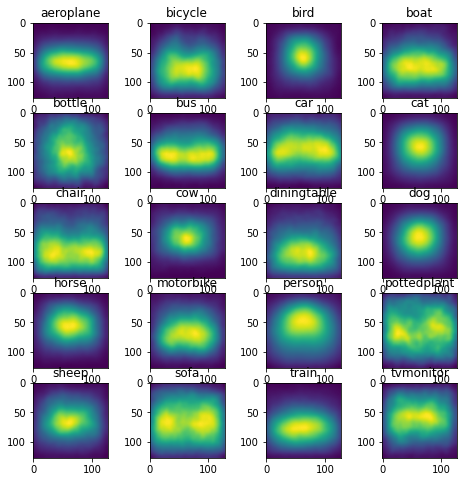

In [12]:
scams = np.load('/Users/Andy/Projects/global_cam.npy', allow_pickle=True) * 1
scams = (scams - np.min(scams)) / (np.max(scams) - np.min(scams))
print(scams.max())
print(scams.min())

object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

w = 128
h = 128
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = torch.from_numpy(scams[i-1])
    img = img.unsqueeze(0).unsqueeze(0)
    img = F.interpolate(img, (128, 128), mode='bilinear', align_corners=False)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.numpy().squeeze())
    plt.title(object_categories[i-1])
plt.show()

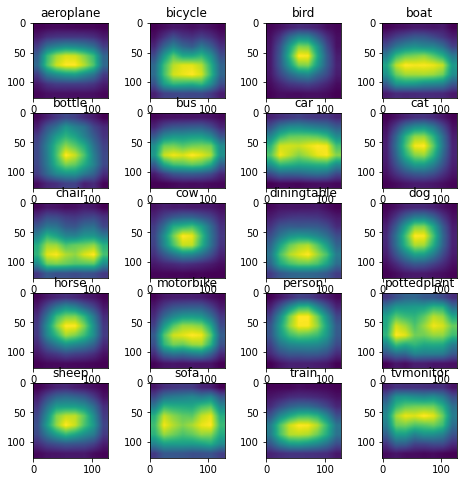

In [4]:
scams = np.load('/Users/Andy/Projects/gcam_dswise_reopt_01.npy10.npy', allow_pickle=True)
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

w = 128
h = 128
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = torch.from_numpy(scams[i-1])
    img = img.unsqueeze(0).unsqueeze(0)
    img = F.interpolate(img, (128, 128), mode='bilinear', align_corners=False)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.numpy().squeeze())
    plt.title(object_categories[i-1])
plt.show()

In [77]:
train_list = 'voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012/'
model_path = '/Users/Andy/Projects/resnet50_frontdoor.pth'
cam_scales = [1.0, 0.5, 1.5, 2.0]

model = Net()
model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=True)

dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(train_list,
                                                         voc12_root=voc12_root,
                                                         scales=cam_scales)
data_loader = DataLoader(dataset, shuffle=False)

data_iter = iter(data_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 3, 500, 334])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


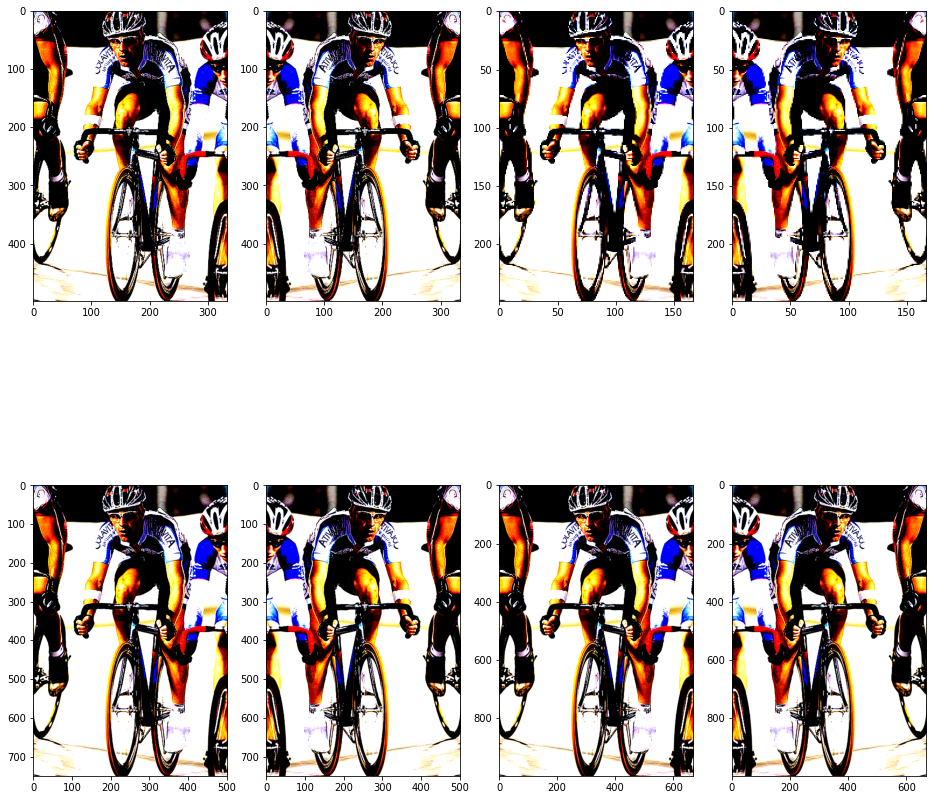

In [78]:
imgs = pack['img']
print(imgs[0].shape)

w = 375
h = 500
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 2
idx = range(1, 9)
ii = 0
for i in range(1, columns + 1):
    for j in range(1, rows + 1):
        img = imgs[i - 1][0][j - 1]
        fig.add_subplot(rows, columns, idx[ii])
        plt.imshow(img.numpy().squeeze().transpose(1, 2, 0))
        ii += 1
plt.show()

In [79]:
outputs = [model(img[0][0].unsqueeze(0)) for img in pack['img']]
print(outputs[0])

tensor([[-389.1536,  236.9529, -329.2698, -899.8867,  -33.9748, -245.6212,
          -34.3395, -196.9152, -417.4730, -608.6698, -189.3853, -153.5312,
         -694.9754, -141.8796,  318.3889, -122.3934, -311.5954, -148.9702,
         -221.7933, -165.7288]], grad_fn=<ViewBackward0>)


In [80]:
print(F.softmax(outputs[0], dim=1))

print(pack['img'][0].shape)

tensor([[0.0000e+00, 4.2933e-36, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]], grad_fn=<SoftmaxBackward0>)
torch.Size([1, 2, 3, 500, 334])


In [47]:
scams = np.load('/Users/Andy/Projects/scam.npy', allow_pickle=True)
scams = torch.from_numpy(scams)
scams = scams.unsqueeze(0)
scams = F.interpolate(scams, (375, 500), mode='bilinear', align_corners=False)
print(scams.shape)

torch.Size([1, 20, 375, 500])


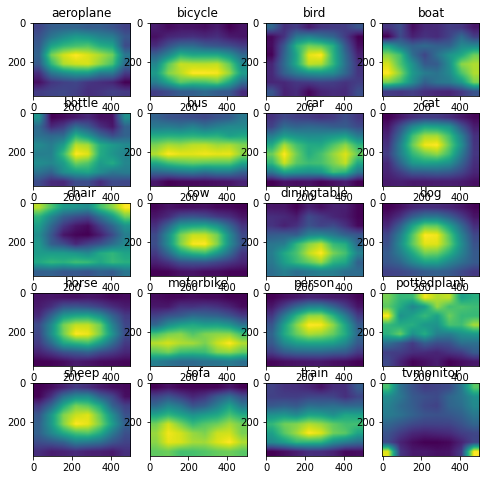

In [49]:
w = 128
h = 500
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
scams= scams.squeeze()
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(scams[i-1].numpy().squeeze())
    plt.title(object_categories[i-1])
plt.show()

torch.Size([1, 20])
torch.Size([20, 375, 500])
torch.Size([1, 375, 500])


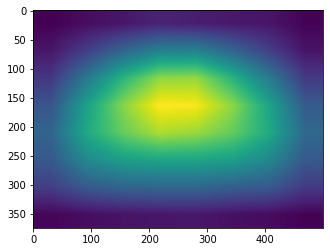

In [83]:
probs = F.softmax(outputs[0], dim=1)
print(probs.shape)
print(scams.shape)
res = probs.unsqueeze(2).unsqueeze(2) * scams.unsqueeze(0)
res = torch.sum(res, dim=1)
print(res.shape)
plt.imshow(res.detach().numpy().squeeze())